<div align='center'>
    <img src='https://static.wixstatic.com/media/b7a8d0_0312a4851d2044d1a61b19fa391bfee6.gif'>
</div>

<div align='center'>
    <h1>Dataset on vehicle brand classification</h1>
    The dataset contains more than 60,000 images of cars of various brands<br>
    Link to dataset competition: <a href=https://www.kaggle.com/datasets/prondeau/the-car-connection-picture-dataset>https://www.kaggle.com/datasets/prondeau/the-car-connection-picture-dataset</a>
</div>

<div align='center'>
    <h3>1.1 Importing libraries and loading data</h3>
</div>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get a list of file names
images = listdir('./Image/') 

# Transfer them to the dataframe
data = pd.DataFrame(images, columns=['src'])

# Getting a car brand from a photo
data['brand'] = data['src'].apply(lambda x : x.split('_')[0].split('/')[-1]) 

data # Let's take a look at the resulting dataframe.

,src,brand
0,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura
1,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura
2,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura
3,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura
4,Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD...,Acura
...,...,...
64462,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo
64463,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo
64464,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo
64465,Volvo_XC90_2020_50_19_250_20_4_79_69_194_18_AW...,Volvo


<div align='center'>
    <h3>1.2 EDA (exploratory data analysis)</h3>
</div>

In [3]:
print(f'Dataset contains {data.shape[0]} records')

Dataset contains 64467 records


In [4]:
brand_unique = len(data['brand'].unique()) 
print(f'Unique auto brands: {brand_unique}')

Unique auto brands: 42


In [5]:
# Let's take a look at the top 10 brands in terms of car popularity in the dataset
data['brand'].value_counts().head(10)

brand
Chevrolet        5079
Toyota           4598
Ford             4416
BMW              4121
Nissan           3881
Audi             3131
Mercedes-Benz    3097
Honda            2675
Kia              2160
Lexus            2125
Name: count, dtype: int64

In [6]:
# Let's take a look at the last 10 brands in terms of car popularity in the dataset
data['brand'].value_counts().tail(10)

brand
Chrysler       570
Maserati       449
smart          386
Alfa Romeo     290
Rolls-Royce    277
Lamborghini    251
Tesla          191
Genesis        176
Ferrari         91
McLaren         72
Name: count, dtype: int64

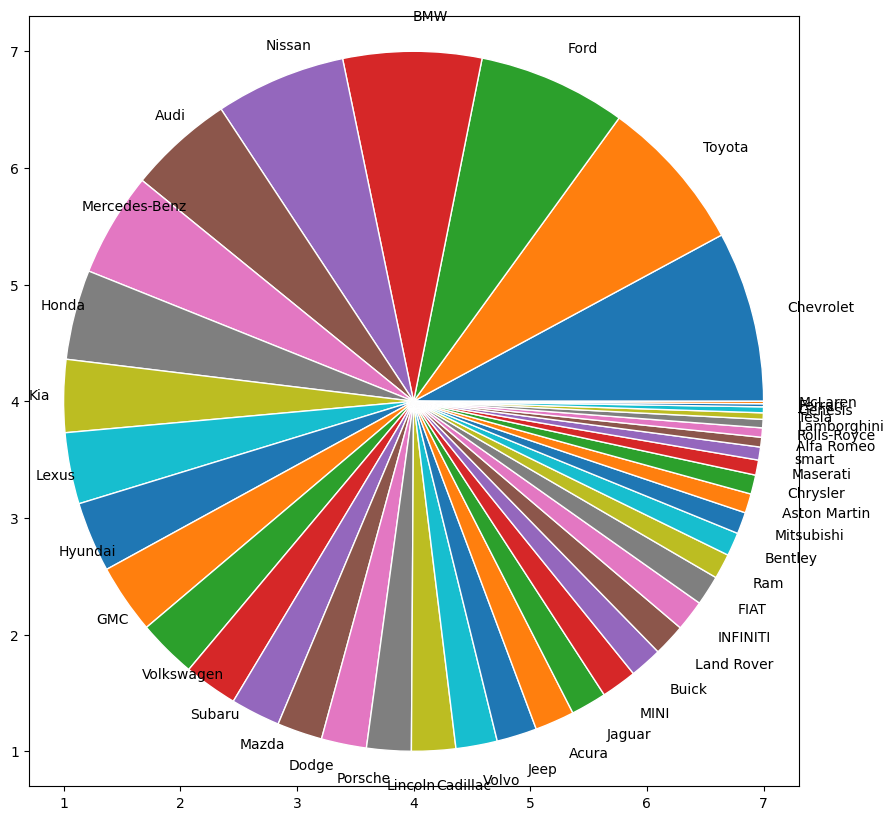

In [7]:
# Visualize the proportion of car brands contained in the entire dataset
fig, ax = plt.subplots(figsize=(25,10))
ax.pie(data['brand'].value_counts() / data.shape[0] * 100 ,labels=data['brand'].value_counts().index,
       radius=3, center=(4, 4), wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

<div align='center'>
    It can be seen that the photos of premium car brands are quite few in the dataset<br>
    The dataset is quite large, and the computing power of my laptop is not enough to process all the photos, so 4 premium car brands (Rolls-Royce, Lamborghini, Tesla, Ferrari) were selected.
</div>

<div align='center'>
    <h3>1.3 Car photo processing </h3>
</div>

CPU times: total: 188 ms
Wall time: 888 ms


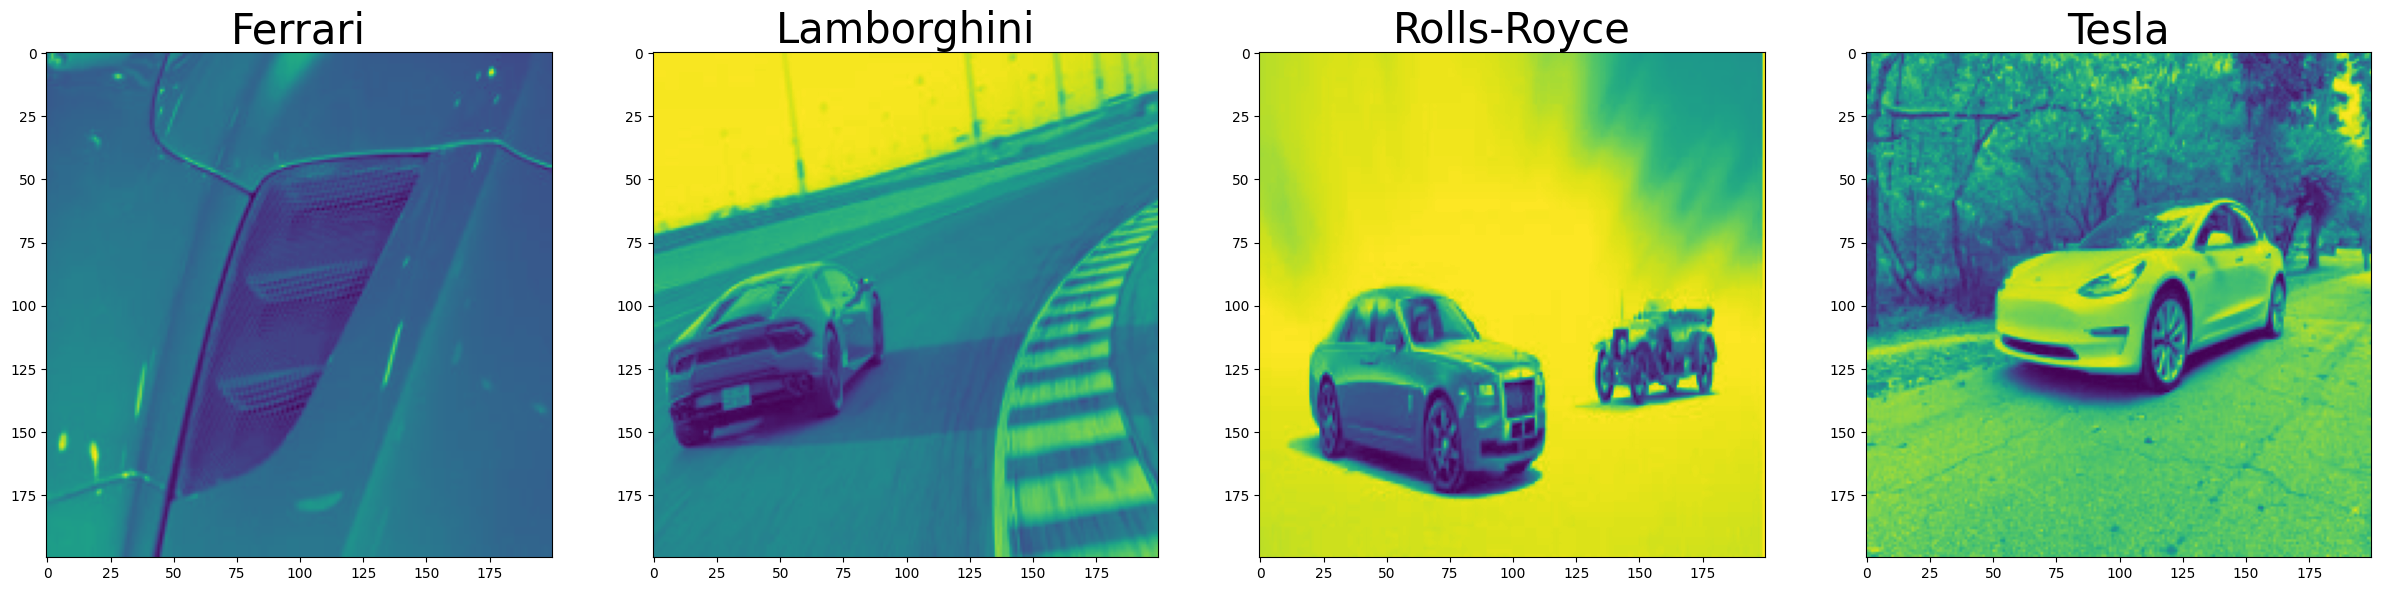

In [8]:
%%time
# Leave photos of the following car brands: Rolls-Royce, Lamborghini, Tesla, Ferrari
data = data[(data['brand']=='Rolls-Royce') | (data['brand']=='Lamborghini') | \
            (data['brand']=='Tesla') | (data['brand']=='Ferrari')].reset_index(drop=True)

# Read, bring to one color channel, resize the image
X = []
y = []
for i in range(len(data)):
    src = data.loc[i,'src'] # Learning the path to the image
    src = cv2.imread('./Image/' + src, cv2.IMREAD_COLOR)
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))
    y.append(data.loc[i, 'brand'])

# Let's take a couple of examples of the resulting photos
count_class = len(data['brand'].unique())
fig, axes = plt.subplots(1, 4, figsize=(30,15), )
for i in range(0,4):
    axes[i].imshow(X[i*data.shape[0]//count_class+19])
    axes[i].set_title(y[i*data.shape[0]//count_class+19], fontsize=30)

<div align='center'>
    You may notice that there are some photos in the dataset from which it is quite difficult to determine the make of the car. For example, on photo #1 is a photo of the air duct grille, from which it is quite problematic to identify the make of the car
</div>

In [9]:
# Нормализируем данные
X_ensemble = np.array(X)
X_ensemble = X_ensemble.astype('float32')
X_ensemble = X_ensemble / 255.0
X_ensemble = X_ensemble.reshape(-1,200*200)

# Кодируем целевую переменную
la_ensemble = LabelEncoder()
y_ensemble = la_ensemble.fit_transform(y)

<div align='center'>
     Photos are translated into numpy arrays, which will speed up work with images several times and will be convenient for training machine learning models on them
</div>

### 2.1 Обучение моделей sklearn

In [10]:
# Create a training and test sample
X_train, X_test, y_train, y_test = train_test_split(X_ensemble, y_ensemble, random_state=42)

# Initialize models
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier(n_neighbors=len(set(y_test)))

# Combine all the models into an ensemble
voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf),('rf', rf_clf),
                ('knn', knn_clf)], voting='hard'
)

<div align='center'>
    Было принято решение обучить модели разных типов по отдельности и в ансамбле, чтобы комплексно подойти к классификации марок автомобилей по фотографиям
</div>

In [11]:
%%time

# Selecting hyperparameters of the RandomForestClassifier model
param_grid = {
    'n_estimators': range(10, 1001, 10),
    'max_depth': range(1, 150),
    'min_samples_split': range(2, 201),
    'min_samples_leaf': range(2, 201),
    'criterion': ['gini', 'entropy']
}
rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid,
                        n_iter=100, cv=3,  n_jobs=-1, scoring='roc_auc')
rf.fit(X_train, y_train)
rf_clf = rf.best_estimator_ 

CPU times: total: 6.64 s
Wall time: 6min 53s


In [12]:
%%time

# Selecting hyperparameters of the LogisticRegression model
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
lr = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=3,  n_jobs=-1, scoring='r2')
lr.fit(X_train, y_train)
lr_clf = lr.best_estimator_ 

CPU times: total: 42.7 s
Wall time: 3min 8s


In [13]:
%%time

# Selecting hyperparameters of KNeighborsClassifier model
param_grid = {
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
}
knn = GridSearchCV(estimator=knn_clf, param_grid=param_grid, cv=3,  n_jobs=-1)
knn.fit(X_train, y_train)
knn_clf = knn.best_estimator_ 

CPU times: total: 78.1 ms
Wall time: 17.2 s


In [14]:
%%time
accuracy_model = {} # Let's write the accuracies of all models in the format {model name: accuracy}

# Train each of the models and see how accurate they are
for clf in (lr_clf, rf_clf, knn_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"{clf.__class__.__name__}: {score}")
    accuracy_model[clf.__class__.__name__] = score

LogisticRegression: 0.4187192118226601
RandomForestClassifier: 0.35467980295566504
KNeighborsClassifier: 0.5320197044334976
VotingClassifier: 0.5123152709359606
CPU times: total: 1min 7s
Wall time: 1min 12s


<div align='center'>
    According to the results, we can see that the KNeighborsClassifier model has shown itself best of all, so we will compare the accuracy of the neural network with this one
</div>

In [15]:
best_name_model = "" # Name of the best model
best_accurasy = 0 # Her accuracy

# Going through all the models and finding the best one
for key in accuracy_model.keys():
    if accuracy_model[key] > best_accurasy:
        best_accurasy = accuracy_model[key]
        best_name_model = key

<div align='center'>
    <h3>2.2 Image processing in RGB channel and neural network training</h3>
</div>

In [15]:
X = []
# Reading, resizing the image
for i in range(len(data)):
    src = data.loc[i,'src'] # Get the path to the image
    src = cv2.imread('./Image/'+src, cv2.IMREAD_COLOR) 
    dst = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    X.append(cv2.resize(dst, dsize=(200, 200), interpolation=cv2.INTER_AREA))

# Normalize the data
X_torch = np.array(X)
X_torch = X_torch.astype('float32')
X_torch = X_torch /255.0
X_torch = X_torch.reshape(-1,3,200,200)

X_torch.shape # Посмотрим на размерность

(810, 3, 200, 200)

In [16]:
# Let's determine the possibility of photo processing on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [17]:
# Form a new training and test sample
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_ensemble, random_state=42)

In [18]:
# Переведём все данные в тензоры и сформируем "пакеты"
X_train_t =  torch.from_numpy(X_train).float()
y_train_t =  torch.from_numpy(y_train)
X_test_t =  torch.from_numpy(X_test).float()
y_test_t =  torch.from_numpy(y_test)
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

<div align='center'>
    The data is in a convenient format for training a neural network<br>
    In order not to invent a "bicycle", let's take one of the lightweight neural network models and add another lazy layer for classification. In my case, we take DenseNet121 neural network.<br>
    Reasons for choosing this neural network: It has a relatively small number of parameters (8 million), for comparison AlexNet has 61 million parameters; Solves the problem of "fading gradient"; Layers do not lose information after each convolution block;<br>
    List of available pre-trained models: <a href='https://pytorch.org/vision/stable/models.html'>https://pytorch.org/vision/stable/models.html</a>
</div>


<div align='center'>
    <img width=75% src='https://pytorch.org/assets/images/densenet1.png', alt='Структура сети DenseNet121'>
</div>

In [19]:
model = models.densenet121() # Loading structure and weights
model.classifier = torch.nn.Linear(1024, len(set(y_test))) # Replacing the classification layer
model.to(device) # Downloading the model to the device

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

<div align='center'>
    <img width=75% alt="GIF" src='https://habrastorage.org/getpro/habr/upload_files/c2e/3dc/816/c2e3dc8160c00bafd9b6320d5eb508f9.gif'>
    <br>
    <img width=75%  src='https://pytorch.org/docs/stable/_images/ReLU.png'>
    <br>
    <img width=75% alt="GIF" src='https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif'>
    <br>
    <img width=75% alt="GIF" src='https://neurohive.io/wp-content/uploads/2018/10/obuchenie-neironnyh-setei-glubokoe.gif'>
</div>

In [20]:
criterion = torch.nn.CrossEntropyLoss() # Error calculation
optimizer = torch.optim.Adam(model.parameters()) # Error gradient calculation
loaders = {"train": train_dataloader, "test": test_dataloader}

<div align='center'>
    <img width=75% alt="GIF" src='https://ml-cheatsheet.readthedocs.io/en/latest/_images/optimizers.gif', alt='Визуализация работы оптимизаторов'>
</div>

In [21]:
max_epochs = 200
best_model = model # Best model
flag = False 
col_not_best = 0 # Количество эпох без изменений
accyracy_best = 0 # Best accuracy 
accuracy = {"train": [], "test": []}
for epoch in range(max_epochs+1):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Transfer data to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad() # Zeroing out the error gradients
                outp = model(x_batch) # Getting answers from the model
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1) # Softmax, we get a class
            correct = (preds == y_batch).sum() # Number of correct answers
            all = preds.size(0) # Number of all answers
            epoch_correct += correct.item() # Number of photos correctly recognized
            epoch_all += all # Total number of photos
            if k == "train":
                loss = criterion(outp, y_batch) # Calculating the graditi
                loss.backward()
                optimizer.step()           
        if k == "train":
            print(f"Эпоха: {epoch+1}")
        print(f"Выборка: {k} Точность: {epoch_correct/epoch_all}")
        
        # Implementing early stopping during retraining
        if k == "test":
            if accyracy_best < epoch_correct/epoch_all:
                col_not_best = 0
                accyracy_best = epoch_correct/epoch_all
                best_model = model
            else:
                if col_not_best + 1 >= 15:
                    print("Остановка обучения!")
                    accuracy[k].append(epoch_correct/epoch_all)
                    flag = True
                    break
                else:
                    col_not_best += 1
                    print(f"Нет роста {col_not_best} эпох")
                    
        accuracy[k].append(epoch_correct/epoch_all)
    if flag:
        break

Эпоха: 1
Выборка: train Точность: 0.3970345963756178
Выборка: test Точность: 0.3891625615763547
Эпоха: 2
Выборка: train Точность: 0.47775947281713343
Выборка: test Точность: 0.4827586206896552
Эпоха: 3
Выборка: train Точность: 0.5387149917627677
Выборка: test Точность: 0.5123152709359606
Эпоха: 4
Выборка: train Точность: 0.6128500823723229
Выборка: test Точность: 0.4236453201970443
Нет роста 1 эпох
Эпоха: 5
Выборка: train Точность: 0.6359143327841845
Выборка: test Точность: 0.4876847290640394
Нет роста 2 эпох
Эпоха: 6
Выборка: train Точность: 0.6968698517298187
Выборка: test Точность: 0.5123152709359606
Нет роста 3 эпох
Эпоха: 7
Выборка: train Точность: 0.7084019769357496
Выборка: test Точность: 0.458128078817734
Нет роста 4 эпох
Эпоха: 8
Выборка: train Точность: 0.7182866556836903
Выборка: test Точность: 0.5566502463054187
Эпоха: 9
Выборка: train Точность: 0.7380560131795717
Выборка: test Точность: 0.49261083743842365
Нет роста 1 эпох
Эпоха: 10
Выборка: train Точность: 0.8138385502471

Dictionary

    "Эпоха" = Epoch
    "Выборка" = Sampling
    "Точность" = Accuracy
    "Нет роста X эпох" = There's no growth in X eras
    "Остановка обучения!" = Stop the research!

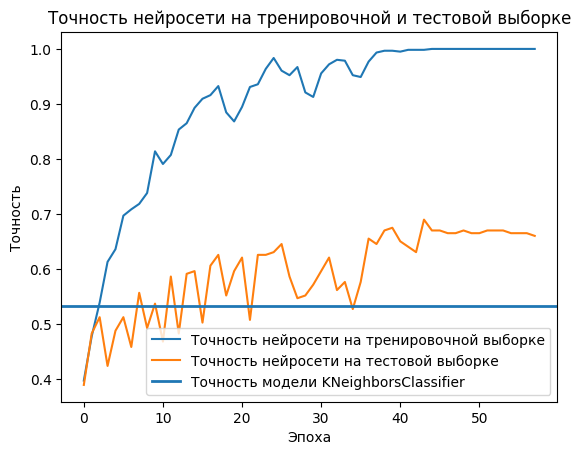

In [22]:
# Visualize the accuracy history of the neural network
plt.plot(accuracy['train'], label='Точность нейросети на тренировочной выборке')
plt.plot(accuracy['test'], label='Точность нейросети на тестовой выборке')
plt.title('Точность нейросети на тренировочной и тестовой выборке')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.axhline(best_accurasy, linewidth=2, label='Точность модели '+best_name_model)
plt.legend()
plt.show()

Dictionary:

    "Точность нейросети на тренировочной выборке" = Accuracy of neural network on training sample
    
    "Точность нейросети на тестовой выборке" = Accuracy of neural network on test sample
    
    "Точность нейросети на тренировочной и тестовой выборке" = Accuracy of neural network on training and test sample
    
    "Точность модели KNeighborsClassifier" = Accuracy of the KNeighborsClassifier model
    
    "Точность" = Accuracy
    
    "Эпоха" = Epoch

<div align='center'>
    <h3>2.3 Let's compare the accuracies of all models and the neural network</h3>
</div>

In [23]:
# Let's look at the accuracy of all the models
df = pd.DataFrame([accuracy_model[key] for key in accuracy_model.keys()]+[max(accuracy['test'])], 
                  index=([key for key in accuracy_model.keys()]+["DenseNet121"]), columns=['Accuracy Test'])
round(df['Accuracy Test'].sort_values(ascending=0)*100, 3)

DenseNet121               68.966
KNeighborsClassifier      53.202
VotingClassifier          51.232
LogisticRegression        41.872
RandomForestClassifier    35.468
Name: Accuracy Test, dtype: float64

<div align='center'>
        According to the results, the convolutional neural network DenseNet121 has a significant gap in the accuracy rate, compared to other models.
</div>

<div align='center'>
    <img src='https://www.westwingclassic.com/wp-content/uploads/2023/02/Thank-you-card-2-preview.jpg'>
</div>